<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/tuning_calc/Merge_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj
! pip install https://github.com/raghakot/keras-vis/archive/master.zip #keras vis

Cloning into 'vgg16obj'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 301 (delta 172), reused 137 (delta 59), pack-reused 0
Receiving objects: 100% (301/301), 4.85 MiB | 12.09 MiB/s, done.
Resolving deltas: 100% (172/172), done.
     - 67.4MB 3.5MB/s
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30856 sha256=030506d1d9ebd788033f906d78da0e8cac2b00908c6b67af1d14c37492e12e34
  Stored in directory: /tmp/pip-ephem-wheel-cache-__cjoq0i/wheels/7e/91/e5/9fdb0f2f5fa5d9f402c6fbfaf015aadbe3dba024ede6532727
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


In [3]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
#!unzip -q /content/drive/My\ Drive/obj/data_6class
!unzip -q /content/drive/My\ Drive/obj/merge


In [1]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle
import cv2
import seaborn as sns


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc
from vgg16obj.tools import stats as st
from vgg16obj.tools import plot_tools as pt


import tensorflow as tf
from tensorflow import math

# Load Images

### Merged Images

In [2]:
def noisy(image):
  row,col,ch= image.shape
  mean = 0
  var = 1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def convertimgs(path,noise = False) :
    data = []
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            if noise:
              im = noisy(im)
            data.append(im) 
    return data

(12, 80, 224, 224, 3) (12, 40, 224, 224, 3)
(12, 80, 224, 224, 3) (12, 40, 224, 224, 3)


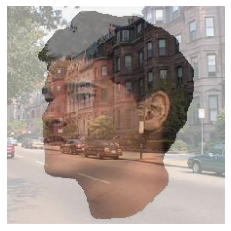

In [3]:
# Merged images load
data_train = [[]  for i in range(12)]
data_train[0] = convertimgs('/content/merge/merge_train/Correct/Male',noise = False)  #75
data_train[1] = convertimgs('/content/merge/merge_train/Correct/Female/',noise = False) #75
data_train[2] = convertimgs('/content/merge/merge_train/Correct/Manmade/',noise = False) #75
data_train[3] = convertimgs('/content/merge/merge_train/Correct/Natural/',noise = False) #75
data_train[4] = convertimgs('/content/merge/merge_train/Correct/Powered',noise = False) #75
data_train[5] = convertimgs('/content/merge/merge_train/Correct/Nonpowered',noise = False) #75

data_train[6] = convertimgs('/content/merge/merge_train/Incorrect/Male',noise = False) #75
data_train[7] = convertimgs('/content/merge/merge_train/Incorrect/Female',noise = False) #75
data_train[8] = convertimgs('/content/merge/merge_train/Incorrect/Manmade',noise = False) #75
data_train[9] = convertimgs('/content/merge/merge_train/Incorrect/Natural',noise = False) #75
data_train[10] = convertimgs('/content/merge/merge_train/Incorrect/Powered',noise = False) #75
data_train[11] = convertimgs('/content/merge/merge_train/Incorrect/Nonpowered',noise = False) #75
data_train = np.array(data_train)
 
data_test = [[]  for i in range(12)]
data_test[0] = convertimgs('/content/merge/merge_test/Correct/Male',noise = False)  #75
data_test[1] = convertimgs('/content/merge/merge_test/Correct/Female/',noise = False) #75
data_test[2] = convertimgs('/content/merge/merge_test/Correct/Manmade/',noise = False) #75
data_test[3] = convertimgs('/content/merge/merge_test/Correct/Natural/',noise = False) #75
data_test[4] = convertimgs('/content/merge/merge_test/Correct/Powered',noise = False) #75
data_test[5] = convertimgs('/content/merge/merge_test/Correct/Nonpowered',noise = False) #75

data_test[6] = convertimgs('/content/merge/merge_test/Incorrect/Male',noise = False) #75
data_test[7] = convertimgs('/content/merge/merge_test/Incorrect/Female',noise = False) #75
data_test[8] = convertimgs('/content/merge/merge_test/Incorrect/Manmade',noise = False) #75
data_test[9] = convertimgs('/content/merge/merge_test/Incorrect/Natural',noise = False) #75
data_test[10] = convertimgs('/content/merge/merge_test/Incorrect/Powered',noise = False) #75
data_test[11] = convertimgs('/content/merge/merge_test/Incorrect/Nonpowered',noise = False) #75
data_test = np.array(data_test)


print(data_train.shape,data_test.shape)

plt.imshow(data_train[0,1])
plt.axis('off')

# Regular Images load

reg_train = [[]  for i in range(12)]
reg_train[0] = convertimgs('/content/merge/merge_reg_train/Correct/Male',noise = False)  # 75
reg_train[1] = convertimgs('/content/merge/merge_reg_train/Correct/Female',noise = False) # 75
reg_train[2] = convertimgs('/content/merge/merge_reg_train/Correct/Manmade',noise = False) # 75
reg_train[3] = convertimgs('/content/merge/merge_reg_train/Correct/Natural/',noise = False) # 75
reg_train[4] = convertimgs('/content/merge/merge_reg_train/Correct/Powered',noise = False) # 75
reg_train[5] = convertimgs('/content/merge/merge_reg_train/Correct/Nonpowered',noise = False) # 75

reg_train[6] = convertimgs('/content/merge/merge_reg_train/Incorrect/Male',noise = False)  # 75
reg_train[7] = convertimgs('/content/merge/merge_reg_train/Incorrect/Female',noise = False) # 75
reg_train[8] = convertimgs('/content/merge/merge_reg_train/Incorrect/Manmade',noise = False) # 75
reg_train[9] = convertimgs('/content/merge/merge_reg_train/Incorrect/Natural/',noise = False) # 75
reg_train[10] = convertimgs('/content/merge/merge_reg_train/Incorrect/Powered',noise = False) # 75
reg_train[11] = convertimgs('/content/merge/merge_reg_train/Incorrect/Nonpowered',noise = False) # 75
reg_train = np.array(reg_train)


reg_test = [[]  for i in range(12)]
reg_test[0] = convertimgs('/content/merge/merge_reg_test/Correct/Male',noise = False)  #75
reg_test[1] = convertimgs('/content/merge/merge_reg_test/Correct/Female/',noise = False) #75
reg_test[2] = convertimgs('/content/merge/merge_reg_test/Correct/Manmade/',noise = False) #75
reg_test[3] = convertimgs('/content/merge/merge_reg_test/Correct/Natural/',noise = False) #75
reg_test[4] = convertimgs('/content/merge/merge_reg_test/Correct/Powered',noise = False) #75
reg_test[5] = convertimgs('/content/merge/merge_reg_test/Correct/Nonpowered',noise = False) #75

reg_test[6] = convertimgs('/content/merge/merge_reg_test/Incorrect/Male',noise = False) #75
reg_test[7] = convertimgs('/content/merge/merge_reg_test/Incorrect/Female',noise = False) #75
reg_test[8] = convertimgs('/content/merge/merge_reg_test/Incorrect/Manmade',noise = False) #75
reg_test[9] = convertimgs('/content/merge/merge_reg_test/Incorrect/Natural',noise = False) #75
reg_test[10] = convertimgs('/content/merge/merge_reg_test/Incorrect/Powered',noise = False) #75
reg_test[11] = convertimgs('/content/merge/merge_reg_test/Incorrect/Nonpowered',noise = False) #75
reg_test = np.array(reg_test)

print(reg_train.shape,reg_test.shape)

# Model

In [4]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])
#plot_model(model,show_shapes=True,expand_nested=True)
#model.save_weights('vgg_w',save_format='h5')

categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
interest = 0
print('Category of interest: ', categories[interest])
train_it = np.concatenate((reg_train[interest],reg_train[interest + 6]))
test_it = np.concatenate((reg_test[interest],reg_test[interest + 6]))
print(train_it.shape,test_it.shape)

start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')
epochs = 30

#train_data = np.load('features_train.npy')
ntrain = 80
train_labels = to_categorical([0] * ntrain + [1]*ntrain)


#test_data = np.load('features_test.npy')
ntest = 40
test_labels = to_categorical([0] * ntest + [1]*ntest) 

losses = 'binary_crossentropy'

top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(2, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
top_model.summary()

es = EarlyStopping(monitor='loss', mode='min', verbose=1)


Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 7.1660003662109375
Test Time: 0.6638362407684326
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
top_dense1 (Dense)           (None, 4096)              102764544 
_________________________________________________________________
predictions (Dense)          (None, 2)                 8194      
Total params: 102,772,738
Trainable params: 102,772,738
Non-trainable params: 0
_________________________________________________________________


In [31]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']

acc = np.zeros((2,6))
for imtype in range(2):
  for cat in range(6):

    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 6])) # Train on regular data
    if imtype == 0: # Regular
      test_it = np.concatenate((reg_test[cat],reg_test[cat + 6])) # Test on merged data
    else:
      test_it = np.concatenate((data_test[cat],data_test[cat + 6])) # Test on merged data
    print(train_it.shape,test_it.shape)


    start = time.time()
    train_data = model.predict(train_it) 
    print(f'Train Time: {time.time() - start}')

    start = time.time()
    test_data = model.predict(test_it) 
    print(f'Test Time: {time.time() - start}')

    history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 0, callbacks = [es])

    out = top_model.evaluate(test_data, test_labels)
    acc[imtype,cat] = out[1]
    print(out)

Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.3512861728668213
Test Time: 0.19966483116149902
3/3 [==============================] - 0s 4ms/step - loss: 0.1005 - accuracy: 0.9500
[0.10050277411937714, 0.949999988079071]
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.34860777854919434
Test Time: 0.19861364364624023
Epoch 00011: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 0.3613 - accuracy: 0.9125
[0.3613351583480835, 0.9125000238418579]
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.3438689708709717
Test Time: 0.1961686611175537
Epoch 00007: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.1037 - accuracy: 0.9625
[0.1037282720208168, 0.9624999761581421]
Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.35187864303588867
Test Time: 0.1961228847503662
3/3 [==============================] - 0s 4ms/step

0.7666666706403097


Text(0, 0.5, 'Binary Classification Acc.')

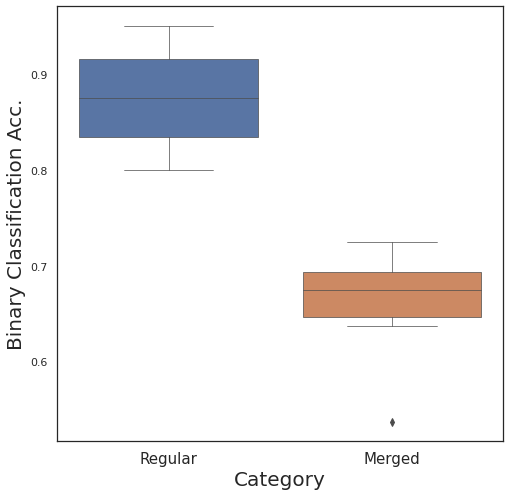

In [20]:
print(np.mean(acc))
import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 0.7})
plt.figure(figsize = (8,8))
ax = sns.boxplot(data = acc.T )
ax.set_xlabel('Category',size = 20)
ax.set_xticklabels(['Regular','Merged'],size = 15)
ax.set_ylabel('Binary Classification Acc.',size = 20)


# Tuning Value Calculation

In [5]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
calc_tun_activ = 0

if calc_tun_activ:
  for cat in range(6): 

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)


    start = time.time()
    tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
    print(f'Elapsed: {time.time() - start}s')

    with open('tuning_values_' + str(cat), 'wb') as fp:
      pickle.dump(tun_activ, fp)



### Load tuning activities

In [6]:
tun_activ = []
for interest in range(6): 
  with open ('/content/drive/My Drive/obj/tuning_values_' + str(interest), 'rb') as fp:
      tun_activ.extend(pickle.load(fp))
len(tun_activ)



240

### Calculation of tuning values for each map

In [7]:
ncats = 6
# to fish out each category tun_activations
labels = np.array([0] * 40 + [1] * 40 + [2] * 40 + [3] * 40 + [4] * 40 + [5] * 40)
cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

for i in range(ncats):
  #Calculating average activity of each
  #feature map in response to images of respective category, 
  #with the mean activity under all image categories subtracted from it
  idx = list(np.where(labels == i))
  cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

# Vector of tuning values for each obj cataegory
fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
#fc has length of ncats x nlayers x no of maps in each layer
for cat in range(ncats):
  for layer in range(len(cat_tun[cat])):
    for map in range(len(cat_tun[cat][layer])):
      if std_tun_activ[layer][map] == 0:
        continue
      fc[cat][layer][map] = (cat_tun[cat][layer][map] - 
                                avg_tun_activ[layer][map])/std_tun_activ[layer][map]


### Tuning quality

(0.0, 50.0)

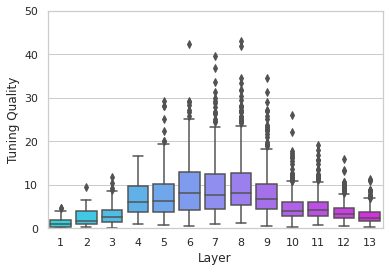

In [8]:
tun_quality = tc.calc_tun_quality(fc)
sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_quality,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,50])

# Gradient Value Calculations

In [ ]:
calc_gradient_val = 0
if calc_gradient_val:
  d_train = data_train.reshape([900,224,224,3])
  labels = np.array([0] * 75 + [1]*75 + [2] * 75 + [3] * 75 + [4] * 75 + [5] * 75 +
                    [0] * 75 + [1]*75 + [2] * 75 + [3] * 75 + [4] * 75 + [5] * 75)
  layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
  cat_grads = [[[] for j in range(len(layer_names))] for i in range(ncats)]


  start = time.time()
  for i in range(ncats):
    idx = list(np.where(labels == i))
    cat_grads[i] = gc.calc_avg_gradcam(d_train[idx],model,top_model)
  print(f'Elapsed: {time.time() - start}s')

  with open('gradient_val_cat_merged', 'wb') as fp:
      pickle.dump(cat_grads, fp)


In [7]:
with open ('/content/drive/My Drive/obj/gradient_val_cat_merged', 'rb') as fp:
    cat_grads = pickle.load(fp)

#cat_grads = [[[-item for item in subl] for subl in level] for level in cat_grads_posivite]
corr_all = st.calc_all_corrcoeff(fc,cat_grads)

import random

cat_grad_s = cat_grads.copy()
random.shuffle(cat_grad_s)
for cat in range(len(cat_grad_s)):
  for layer in range(len(cat_grad_s[cat])):
    random.shuffle(cat_grad_s[cat][layer])

corr_shuff = st.calc_all_corrcoeff(fc,cat_grad_s)
pt.plot_corr(corr_shuff,corr_all,figsize = (10,4))

NameError: ignored

In [5]:
with open ('/content/drive/My Drive/obj/gradient_val_cat_merged', 'rb') as fp:
    cat_grads = pickle.load(fp)

# Attention

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 10 02:39:43 2020

@author: soukhind
"""
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import relu
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.callbacks import EarlyStopping
from vis.utils import utils
from tensorflow.python.ops import nn
from tensorflow import math
import time

def gen_attnmap(modifier,mask,category,bi,atype):
    """
    

    Parameters
    ----------
    modifier : list
        modifier to be used to implement attention.
    mask : ndarray
        binary vector to determine which layer to apply attention at. 
        include attention strength by multiplying to it
    category : ndarray
        cateogies .
    bi : boolean 
        bidirectionality
        True & False.
    atype: int
        1 = Multiplicative
        2 = Additive
    Returns
    -------
    tensor_attnmap : tensor
        attention map.

    """
    attnmap = []
    beta = calc_beta(avg_tun_activ)
  
    #conv1_1 & conv1_2
    for layer in range(2):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((224,224,64),dtype='float32') + np.tile(mapval,[224,224,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[224,224,1])* mask[layer]*beta[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv2_1 & conv2_2
    for layer in range(2,4):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((112,112,128),dtype='float32') + np.tile(mapval,[112,112,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[112,112,1])* mask[layer]*beta[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv3_1 - conv3_3
    for layer in range(4,7):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((56,56,256),dtype='float32') + np.tile(mapval,[56,56,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[56,56,1])* mask[layer]*beta[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv4_1 - conv4_3
    for layer in range(7,10):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((28,28,512),dtype='float32') + np.tile(mapval,[28,28,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[28,28,1])* mask[layer]*beta[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv5_1 - conv5_3
    for layer in range(10,13):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype ==1:
          amap = np.ones((14,14,512),dtype='float32') + np.tile(mapval,[14,14,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[14,14,1])* mask[layer]*beta[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    tensor_attnmap = []
    for layer in range(len(attnmap)):
      tensor_attnmap.append(tf.convert_to_tensor(attnmap[layer])) 
    
    return tensor_attnmap



def avg_accuracy(data_train,train_labels,
                 data_test,test_labels,
                 modifier,
                 model,top_model,idxpath,
                 category,
                 atstrng,
                 bidir = True,
                 atype = 1):
    """
    

    Parameters
    ----------
    data_train : ndarray
        Training data.
    train_labels : categorical
        Training labels.
    data_test : ndarray
        Testing data.
    test_labels : categorical
        Testing labels.
    categories : ndarray
        Names of each category.
    modifier : list
        modifier to be used to implement attention.
    model : keras model
        base model.
    top_model : keras model
        top model.
    idxpath : string
        for internal use.
    atstrng : float32
        attention strength.
    bidir : bool, optional
        Bidirectionality. The default is True.
    atype: int
        1 = Multiplicative
        2 = Additive
    Returns
    -------
    t_acc
        Accuracy for each category at each layer.

    """
    

    epochs = 30    
    n_layers = 13
    t_acc = np.zeros(n_layers)
    for li in range(n_layers):
        layermask = np.zeros(13)
        layermask[li] = 1
        tensor_attnmap = gen_attnmap(modifier,layermask*atstrng,category,bidir,atype)
                

        def attnrelu(x,map = tensor_attnmap,atype = atype):
            layeridx = np.load(idxpath)
            if layeridx == 13:
                layeridx = 0
            if atype == 1:
              x = nn.relu(x)
              activations = math.multiply(x,map[layeridx])
            if atype == 2:
              activations = math.add(x,map[layeridx])
              activations = nn.relu(activations)
            layeridx += 1
            np.save(idxpath,layeridx)
            return activations
    
        get_custom_objects().update({'attnrelu': Activation(attnrelu)})
    
        for layer in model.layers:
            if(hasattr(layer,'activation')):
                layer.activation = attnrelu
    
        utils.apply_modifications(model)
        model.compile()
    
        f_train = model.predict(data_train)     
    
        f_test = model.predict(data_test)
        es = EarlyStopping(monitor='loss', mode='min', verbose=1)
  
        history = top_model.fit(x = f_train,  y = train_labels,
                epochs=epochs,
                batch_size=64,
                verbose = 0, callbacks = [es])
    
        out = top_model.evaluate(f_test, test_labels)
        t_acc[li] = out[1]
        

    return t_acc

def calc_beta(avg_act):
  beta = [0 for item in avg_act]
  for layer in range(len(avg_act)):
    for item in avg_act[layer]:
      beta[layer] += np.mean(item)
  return beta

In [10]:
#@title Multiplicative and bidirectionality corrected

from vgg16obj.tools import model_calcs as mc
import gc
#cat_grads = [[[-item for item in subl] for subl in level] for level in cat_grads]
layeridx = 0
np.save('layeridx',layeridx)
atstrng = 1
grand_acc = [[] for i in range(6)] 
for cat in range(6):
  print('Category of interest: ', categories[cat])
  train_it = np.concatenate((reg_train[cat],reg_train[cat + 6]))
  test_it = np.concatenate((data_test[cat],data_test[cat + 6]))
  print(train_it.shape,test_it.shape)
  grand_acc[cat] = avg_accuracy(train_it,
                            train_labels,
                            test_it,
                            test_labels,
                            fc,
                            model,
                            top_model,
                            '/content/layeridx.npy',
                            cat,
                            atstrng,
                            bidir = True,
                            atype = 2)
  gc.collect()



Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Epoch 00029: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.5250
Epoch 00002: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.5125
Epoch 00003: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.5500
Epoch 00005: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.7020 - accuracy: 0.5000
Epoch 00005: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.9355 - accuracy: 0.5000
Epoch 00007: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 1.0537 - accuracy: 0.5000
Epoch 00002: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 7.6685 - accuracy: 0.5000 


KeyboardInterrupt: ignored

In [8]:
grand_acc = np.array(grand_acc)
grand_acc.reshape([1,6,13])
np.save('grad_accuracy_new' + str(atstrng),grand_acc)

Text(0, 0.5, 'Avg. acc.')

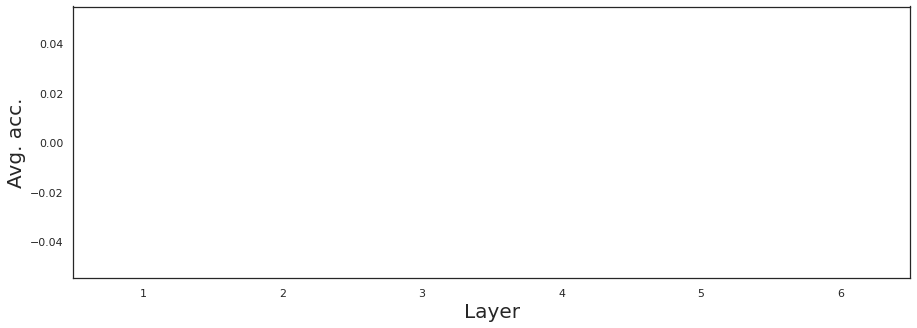

In [27]:
import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 0.7})
plt.figure(figsize = (15,5))
ax = sns.pointplot(data = grand_acc, color = 'mediumseagreen',
                   errorwidth = 0.1 , capsize = 0.2)
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Avg. acc.',size = 20)


### Regular Accuracy

In [32]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
acc = [0]*6
for cat in range(6):
  print('Category of interest: ', categories[cat])
  train_it = np.concatenate((reg_train[cat],reg_train[cat + 6]))
  test_it = np.concatenate((data_test[cat],data_test[cat + 6]))
  print(train_it.shape,test_it.shape)


  #plot_model(model,show_shapes=True,expand_nested=True)
  #model.save_weights('vgg_w',save_format='h5')

  features_train = model.predict(train_it) 

  features_test = model.predict(test_it) 


  epochs = 30
  #train_data = np.load('features_train.npy')
  ntrain = 80
  train_data = features_train
  train_labels = to_categorical([0] * ntrain + [1]*ntrain)


  #test_data = np.load('features_test.npy')
  ntest = 40
  test_data = features_test
  test_labels = to_categorical([0] * ntest + [1]*ntest)



  es = EarlyStopping(monitor='loss', mode='min', verbose=1)

  history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 0, callbacks = [es])

  out = top_model.evaluate(test_data, test_labels)
  print(out)
  acc[cat] = out[1]
  #print('rounded test labels',pred)
np.mean(acc)

Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Epoch 00006: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 1.3734 - accuracy: 0.5500
[1.3733532428741455, 0.550000011920929]
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 4ms/step - loss: 1.0250 - accuracy: 0.6875
[1.025019884109497, 0.6875]
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)
Epoch 00012: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.4089 - accuracy: 0.8250
[0.4089326858520508, 0.824999988079071]
Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 4ms/step - loss: 0.9044 - accuracy: 0.6625
[0.9043550491333008, 0.6625000238418579]
Category of interest:  Powered
(160, 224, 224, 3) (80, 224, 224, 3)
Epoch 00011: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.6669 - accuracy: 0.6875
[0.666

0.6729166706403097

Text(0, 0.5, 'Performance Increase (%)')

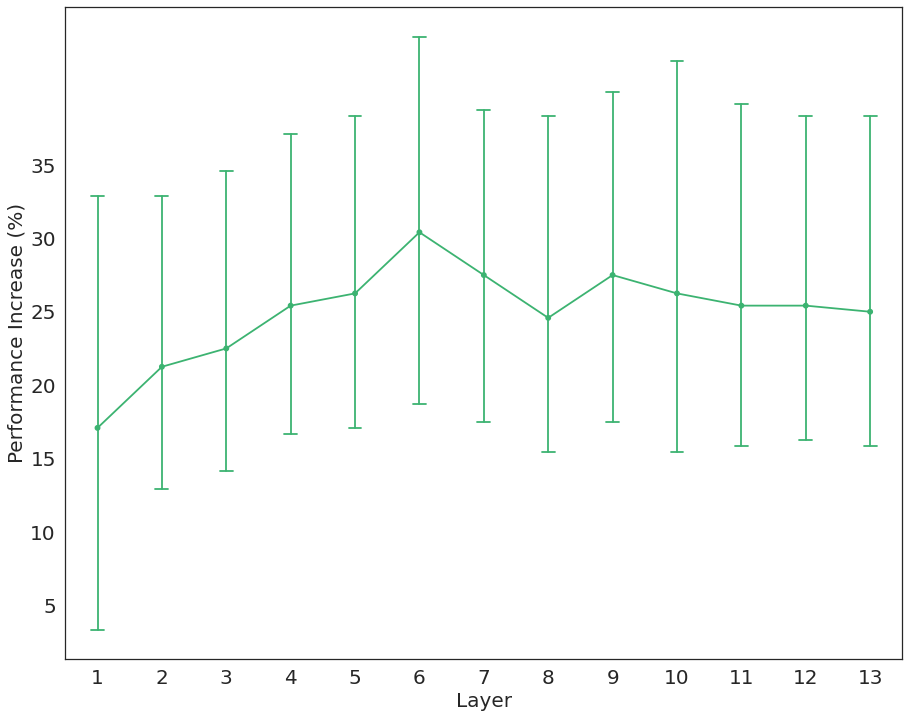

In [35]:
import numpy as np
import matplotlib.pyplot as plt

x = np.load('tun_accuracy_new0.npy')
x = np.expand_dims(x,0)

temp = np.load('tun_accuracy_new0.5.npy')
temp = np.expand_dims(temp,0)
x = np.vstack((x,temp))

temp = np.load('tun_accuracy_new0.npy')
temp = np.expand_dims(temp,0)
x = np.vstack((x,temp))


x = np.amax(x,0)

plt_data = np.zeros((6,13))
for i in range(6):
  for j in range(13):
    plt_data[i,j] = x[i,j] - acc[i]


import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 1})
plt.figure(figsize = (15,12))
ax = sns.pointplot(data = plt_data*100, color = 'mediumseagreen',
                   errorwidth = 0.1 , capsize = 0.2)
                   
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14),size = 20)
ax.set_yticklabels(np.arange(0,40,5),size = 20)
ax.set_ylabel('Performance Increase (%)',size = 20)

In [36]:
#grad_acc = plt_data
tun_acc = plt_data

Text(0, 0.5, 'Performance Increase (%)')

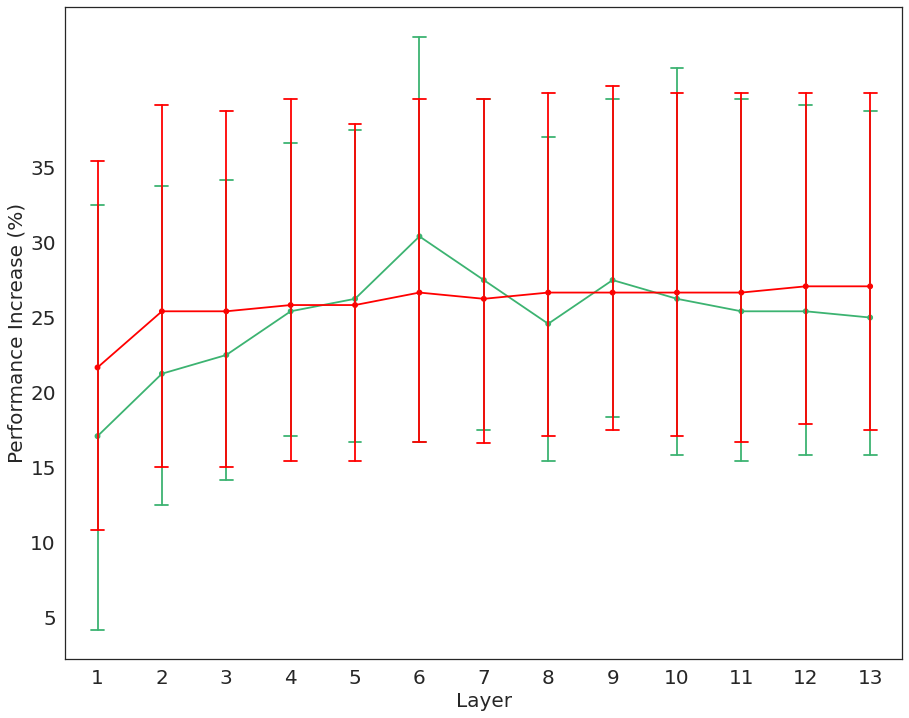

In [37]:
import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 1})
plt.figure(figsize = (15,12))
ax = sns.pointplot(data = tun_acc*100, color = 'mediumseagreen',
                   errorwidth = 0.1 , capsize = 0.2)
ax = sns.pointplot(data = grad_acc*100, color = 'red',
                   errorwidth = 0.1 , capsize = 0.2)                  
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14),size = 20)
ax.set_yticklabels(np.arange(0,40,5),size = 20)
ax.set_ylabel('Performance Increase (%)',size = 20)

In [38]:
#grad_acc = plt_data
#tun_acc = plt_data

from scipy import stats
pval = np.zeros(13)

for i in range(13):
  _,pval[i] = stats.ttest_ind(tun_acc[:,i],grad_acc[:,i],equal_var=False)

pval

array([0.6772562 , 0.66354129, 0.75575651, 0.96407284, 0.9641933 ,
       0.71791762, 0.89453195, 0.82664436, 0.92793235, 0.96884938,
       0.89827658, 0.86144197, 0.8288198 ])